In [1]:
%pylab inline
import numpy as np
import os
from sklearn import cross_validation as crossval
from sklearn.decomposition import RandomizedPCA
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
def reformat(data):
    x = data[:,1:]
    classes = data[:,0].astype(np.int)
    K = max(classes)+1
    N = x.shape[0]
    y = np.zeros((N,K))
    y[np.arange(N),classes] = 1
    return x, y, classes

In [3]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    # Helper function to plot a gallery of portraits
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [4]:
DATA_DIR = os.path.dirname(os.getcwd())
data = np.loadtxt(os.path.join(DATA_DIR, "train.csv"), dtype=np.int, delimiter=",")
datat = np.loadtxt(os.path.join(DATA_DIR, "test2.csv"), dtype=np.int, delimiter=",")
print len(data)

28709


In [11]:
N = len(data)
data1 = data[8*N/10:9*N/10,:]
data2 = data[9*N/10:,:]

In [16]:
# X = pca extraction (includes training but not validation)
# Xtv = training + val
# X1 = train
# X2 = val
X, Y, C = reformat(data[:9*N/10,:])
Xtv, Ytv, Ctv = reformat(data[4*N/5:,:])
X1, Y1, C1 = reformat(data1)
X2, Y2, C2 = reformat(data2)

In [17]:
# Xt = test
Xt, Yt, Ct = reformat(datat)

In [18]:
pca = RandomizedPCA(n_components=150, whiten=True)
pca.fit(X) # fit pca to training data
Xnew = pca.transform(Xtv)
X1new = pca.transform(X1)
X2new = pca.transform(X2)
Xtnew = pca.transform(Xt)

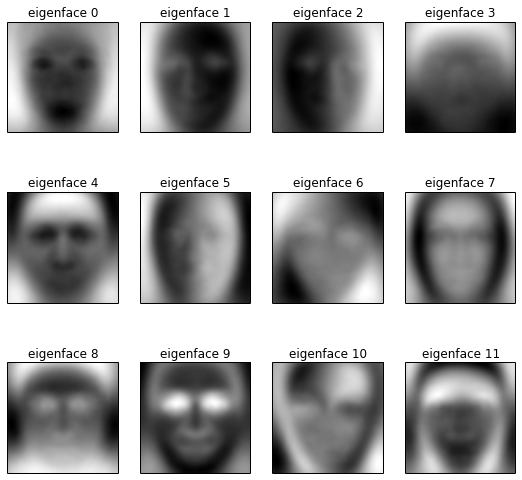

In [19]:
eigenfaces = pca.components_.reshape((150, 48, 48))
titles = ["eigenface %i" % i for i in range(len(eigenfaces))]
plot_gallery(eigenfaces, titles, 48, 48)

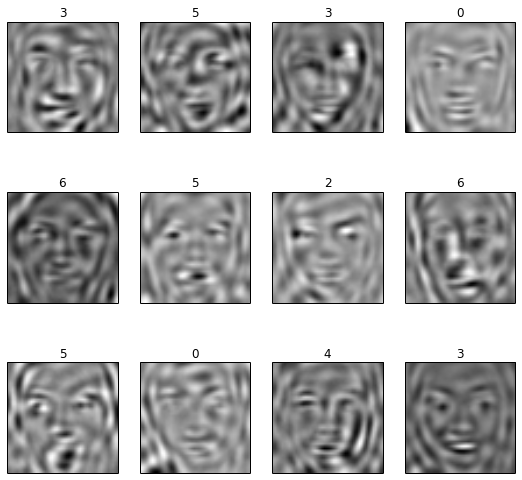

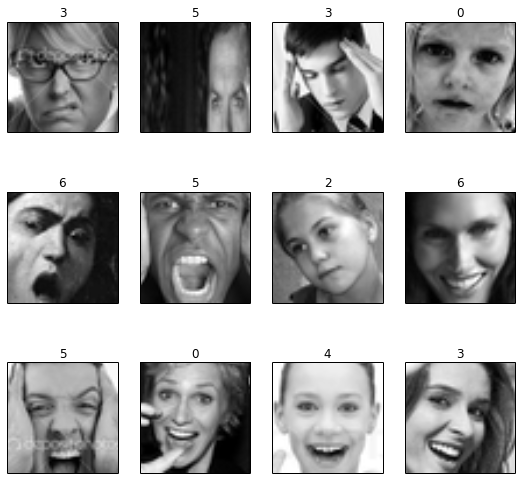

In [59]:
disp = Xtnew[:12]
titles = C1[:12]
projs = X1new.dot(pca.components_)
plot_gallery(projs.reshape((len(projs), 48, 48)), titles, 48, 48)
plot_gallery(Xt.reshape((len(Xt), 48, 48)), C1, 48, 48)

In [34]:
idx = np.arange(len(Xnew))
valsplit = [(idx[:len(X1)], idx[len(X1):])]

In [35]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=valsplit)

In [36]:
clf = clf.fit(Xnew, Ctv)

In [83]:
print clf.grid_scores_
print clf.best_score_

[mean: 0.33891, std: 0.00000, params: {'C': 1000.0, 'gamma': 0.0001}, mean: 0.34239, std: 0.00000, params: {'C': 1000.0, 'gamma': 0.0005}, mean: 0.34518, std: 0.00000, params: {'C': 1000.0, 'gamma': 0.001}, mean: 0.35876, std: 0.00000, params: {'C': 1000.0, 'gamma': 0.005}, mean: 0.35354, std: 0.00000, params: {'C': 1000.0, 'gamma': 0.01}, mean: 0.26088, std: 0.00000, params: {'C': 1000.0, 'gamma': 0.1}, mean: 0.34552, std: 0.00000, params: {'C': 5000.0, 'gamma': 0.0001}, mean: 0.34204, std: 0.00000, params: {'C': 5000.0, 'gamma': 0.0005}, mean: 0.34413, std: 0.00000, params: {'C': 5000.0, 'gamma': 0.001}, mean: 0.35876, std: 0.00000, params: {'C': 5000.0, 'gamma': 0.005}, mean: 0.35354, std: 0.00000, params: {'C': 5000.0, 'gamma': 0.01}, mean: 0.26088, std: 0.00000, params: {'C': 5000.0, 'gamma': 0.1}, mean: 0.34413, std: 0.00000, params: {'C': 10000.0, 'gamma': 0.0001}, mean: 0.34204, std: 0.00000, params: {'C': 10000.0, 'gamma': 0.0005}, mean: 0.34413, std: 0.00000, params: {'C': 10

In [86]:
clf.score(X2new, C2)

0.99930337861372343

In [39]:
clf.score(Xtnew, Ct)

0.38590136528280861

In [73]:
def make_nn(M, d, k, lam1=1e-3, lam2=1e-3):
    x = tf.placeholder("float", [None, d])   
    W1 = tf.Variable(tf.random_uniform([d, M], -0.5, 0.5))
    l1 = tf.nn.sigmoid(tf.matmul(x, W1))
    W2 = tf.Variable(tf.random_uniform([M, k], -0.5, 0.5))
    y = tf.nn.softmax(tf.matmul(l1, W2))
    y_ = tf.placeholder("float", [None, k])
    cross_entropy = -tf.reduce_sum(y_*tf.log(y)) + lam1 * tf.nn.l2_loss(W1) + lam2 * tf.nn.l2_loss(W2)
    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(cross_entropy)
    init = tf.initialize_all_variables()
    return init, train_step, x, y, y_

In [72]:
def make_nn2(M1, M2, d, k, lam1, lam2, lam3):
    x = tf.placeholder("float", [None, d])   
    W1 = tf.Variable(tf.random_uniform([d, M1], -0.5, 0.5))
    l1 = tf.nn.sigmoid(tf.matmul(x, W1))
    W2 = tf.Variable(tf.random_uniform([M1, M2], -0.5, 0.5))
    l2 = tf.nn.sigmoid(tf.matmul(l1, W2))
    W3 = tf.Variable(tf.random_uniform([M2, k], -0.5, 0.5))
    y = tf.nn.softmax(tf.matmul(l2, W3))
    y_ = tf.placeholder("float", [None, k])
    cross_entropy = -tf.reduce_sum(y_*tf.log(y)) + lam1 * tf.nn.l2_loss(W1) + lam2 * tf.nn.l2_loss(W2) + lam3 * tf.nn.l2_loss(W3)
    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(cross_entropy)
    init = tf.initialize_all_variables()
    return init, train_step, x, y, y_

In [74]:
init, train_step, x, y, y_ = make_nn(100, X1new.shape[1], Y1.shape[1])

In [75]:
sess = tf.Session()
sess.run(init)
for i in range(5000):
#     idx = i % N
#     sess.run(train_step, feed_dict={x: Xnew[idx:idx+1], y_: Y[idx:idx+1]})
    sess.run(train_step, feed_dict={x: Xnew[:len(Xnew)/2], y_: Ytv[:len(Ytv)/2]})
    sess.run(train_step, feed_dict={x: Xnew[len(Xnew)/2:], y_: Ytv[len(Ytv)/2:]})

In [76]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [78]:
print sess.run(accuracy, feed_dict={x: X1new, y_: Y1})
print sess.run(accuracy, feed_dict={x: Xtnew, y_: Yt})

0.998955
0.309557


In [60]:
init, train_step, x, y, y_ = make_nn2(10, 10, X1new.shape[1], Y1.shape[1])

In [66]:
M1 = 10; M2 = 10; d = X1new.shape[1]; k = Y1.shape[1]

In [67]:
x = tf.placeholder("float", [None, d])   
W1 = tf.Variable(tf.random_uniform([d, M1], -0.5, 0.5))
l1 = tf.nn.sigmoid(tf.matmul(x, W1))
W2 = tf.Variable(tf.random_uniform([M1, M2], -0.5, 0.5))
l2 = tf.nn.sigmoid(tf.matmul(l1, W2))
W3 = tf.Variable(tf.random_uniform([M2, k], -0.5, 0.5))
y = tf.nn.softmax(tf.matmul(l2, W3))
y_ = tf.placeholder("float", [None, k])
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(cross_entropy)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(5000):
#     idx = i % N
#     sess.run(train_step, feed_dict={x: Xnew[idx:idx+1], y_: Y[idx:idx+1]})
    sess.run(train_step, feed_dict={x: Xnew[:len(Xnew)/2], y_: Ytv[:len(Ytv)/2]})
    sess.run(train_step, feed_dict={x: Xnew[len(Xnew)/2:], y_: Ytv[len(Ytv)/2:]})
sess.run(accuracy, feed_dict={x: X1new, y_: Y1})
sess.run(accuracy, feed_dict={x: Xtnew, y_: Yt})   

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_5' with dtype float
	 [[Node: Placeholder_5 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Placeholder_5', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 403, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-bdeb9f0c8fbf>", line 1, in <module>
    init, train_step, x, y, y_ = make_nn(100, X1new.shape[1], Y1.shape[1])
  File "<ipython-input-47-ea90eef4716e>", line 2, in make_nn
    x = tf.placeholder("float", [None, d])
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 651, in placeholder
    name=name)
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 463, in _placeholder
    name=name)
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 633, in apply_op
    op_def=op_def)
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1710, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 988, in __init__
    self._traceback = _extract_stack()


In [64]:
sess.run(accuracy, feed_dict={x: X1new, y_: Y1})
sess.run(accuracy, feed_dict={x: Xtnew, y_: Yt})

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_5' with dtype float
	 [[Node: Placeholder_5 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Placeholder_5', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 403, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-bdeb9f0c8fbf>", line 1, in <module>
    init, train_step, x, y, y_ = make_nn(100, X1new.shape[1], Y1.shape[1])
  File "<ipython-input-47-ea90eef4716e>", line 2, in make_nn
    x = tf.placeholder("float", [None, d])
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 651, in placeholder
    name=name)
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 463, in _placeholder
    name=name)
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 633, in apply_op
    op_def=op_def)
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1710, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/vickieye/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 988, in __init__
    self._traceback = _extract_stack()
